In [17]:
import pandas as pd
import os
from dotenv import load_dotenv
from pymongo import MongoClient
import matplotlib.pyplot as plt
import numpy as np

In [18]:
load_dotenv()

client = MongoClient(os.getenv("MONGO_CONNECTION_STRING"))
print("Connected to MongoDB")

db = client[os.getenv("MONGO_DB_NAME")]

env_type = os.getenv("ENV_TYPE")
print("env:", env_type)

if env_type == "dev":
    collection_name = os.getenv("DEV_MONGO_COLLECTION")
    print("Using dev collection")
else:
    collection_name = os.getenv("PROD_MONGO_COLLECTION")
    print("Using prod collection")

collection = db[collection_name]
print("Using collection:", collection_name)

Connected to MongoDB
env: prod
Using prod collection
Using collection: Results


In [19]:
cursor = collection.find({})
data = list(cursor)

results = {
    "gpt-4o": {
        "question_correct": [],
        "answers_correct": [],
        "interesting_question": []
    },
    "gemini-1.5-pro": {
        "question_correct": [],
        "answers_correct": [],
        "interesting_question": []
    },
    "gemini-2.0-flash": {
        "question_correct": [],
        "answers_correct": [],
        "interesting_question": []
    },
    "claude-3-5-sonnet-20241022": {
        "question_correct": [],
        "answers_correct": [],
        "interesting_question": []
    },
    "claude-3-7-sonnet-latest": {
        "question_correct": [],
        "answers_correct": [],
        "interesting_question": []
    },
}

for d in data:
    model = d["model"]
    results[model]["question_correct"].append(d["question_correct"])
    results[model]["answers_correct"].append(d["answers_correct"])
    results[model]["interesting_question"].append(d["interesting_question"])

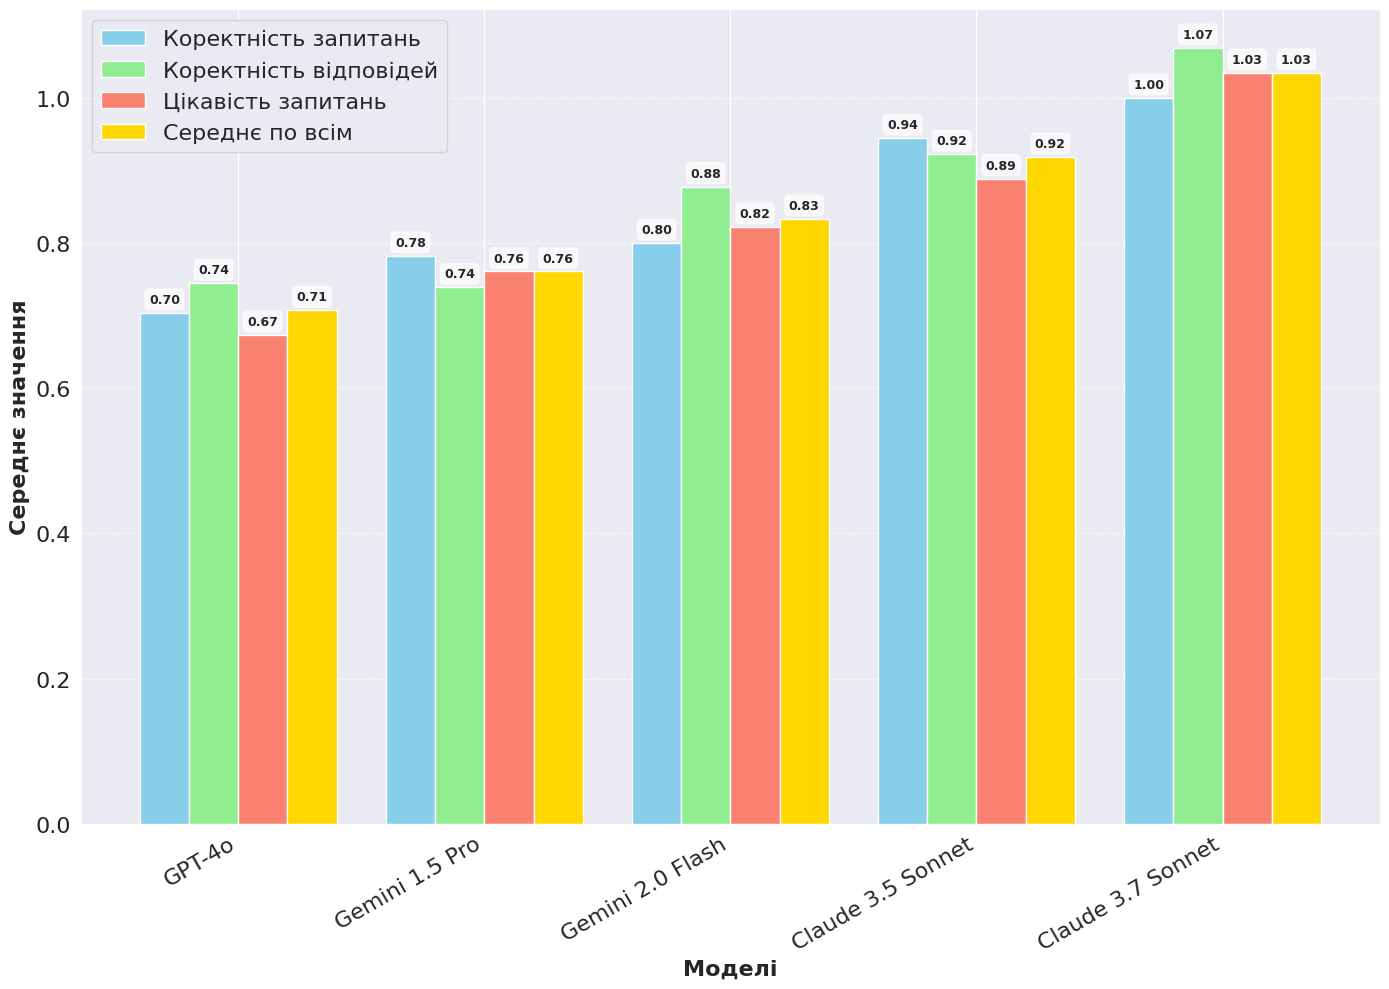

In [35]:
# Розрахунок статистики для кожної моделі та метрики
models = list(results.keys())
metrics = ["question_correct", "answers_correct", "interesting_question"]

# Коротші назви моделей для відображення
model_display_names = {
    "gpt-4o": "GPT-4o",
    "gemini-1.5-pro": "Gemini 1.5 Pro",
    "gemini-2.0-flash": "Gemini 2.0 Flash",
    "claude-3-5-sonnet-20241022": "Claude 3.5 Sonnet",
    "claude-3-7-sonnet-latest": "Claude 3.7 Sonnet"
}

# Підготовка даних для графіку та таблиці
stats_data = []
means_for_plot = []

for model in models:
    model_means = {}
    overall_sum = 0

    for metric in metrics:
        values = results[model][metric]
        values_array = np.array(values)

        mean_val = np.mean(values_array)
        median_val = np.median(values_array)
        percentile_75 = np.percentile(values_array, 75)
        min_val = np.min(values_array)
        max_val = np.max(values_array)

        # Додати дані для таблиці
        stats_data.append({
            "Model": model_display_names[model],
            "Metric": metric,
            "Mean": mean_val,
            "Median": median_val,
            "75th Percentile": percentile_75,
            "Min": min_val,
            "Max": max_val
        })

        # Зберегти середні значення для графіку
        model_means[metric] = mean_val
        overall_sum += mean_val

    # Розрахунок загального середнього для моделі
    model_means["overall"] = overall_sum / len(metrics)

    # Додати загальне середнє значення в таблицю
    stats_data.append({
        "Model": model_display_names[model],
        "Metric": "Середнє по всім",
        "Mean": model_means["overall"],
        "Median": "-",
        "75th Percentile": "-",
        "Min": "-",
        "Max": "-"
    })

    # Додати дані для графіку
    model_means["model"] = model_display_names[model]
    means_for_plot.append(model_means)

# Перетворення даних у DataFrame для легшої обробки
df_stats = pd.DataFrame(stats_data)
df_means = pd.DataFrame(means_for_plot)

# 1. Створення графіка з середніми значеннями
plt.figure(figsize=(14, 10))

# Функція для додавання підписів значень на стовпчики
def add_value_labels(ax, spacing=5):
    """Додає підписи значень над стовпчиками."""
    for rect in ax.patches:
        # Отримуємо координати стовпчика
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x() + width/2
        y = height

        # Форматуємо значення
        value = '{:.2f}'.format(height)

        # Створюємо підпис
        ax.annotate(
            value,                      # Текст підпису
            xy=(x, y),                  # Позиція підпису
            xytext=(0, spacing),        # Зміщення підпису
            textcoords="offset points", # Відносні координати
            ha='center',                # Горизонтальне вирівнювання
            va='bottom',                # Вертикальне вирівнювання
            fontsize=9,                 # Розмір шрифту
            fontweight='bold',          # Жирний шрифт
            bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7) # Фон підпису
        )

# Налаштування позицій для стовпчиків
bar_width = 0.2
index = np.arange(len(models))

# Створюємо осі для використання функції додавання підписів
ax = plt.gca()

# Побудова стовпчиків для кожної метрики
bars1 = ax.bar(index - bar_width, df_means["question_correct"], bar_width,
        label='Коректність запитань', color='skyblue')
bars2 = ax.bar(index, df_means["answers_correct"], bar_width,
        label='Коректність відповідей', color='lightgreen')
bars3 = ax.bar(index + bar_width, df_means["interesting_question"], bar_width,
        label='Цікавість запитань', color='salmon')
bars4 = ax.bar(index + 2*bar_width, df_means["overall"], bar_width,
        label='Середнє по всім', color='gold')

# Додаємо підписи значень до стовпчиків
add_value_labels(ax)

# Налаштування графіку
plt.xlabel('Моделі', fontsize=16, fontweight='bold')
plt.ylabel('Середнє значення', fontsize=16, fontweight='bold')
plt.xticks(index + bar_width/2, df_means["model"], rotation=30, ha='right', fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Додавання відступів для кращого відображення
plt.tight_layout()

# Збереження графіку
plt.savefig('model_performance_chart.png', dpi=300, bbox_inches='tight')

In [32]:
# Розрахунок статистики для кожної моделі та метрики
models = list(results.keys())
metrics = ["question_correct", "answers_correct", "interesting_question"]

# Коротші назви моделей для відображення
model_display_names = {
    "gpt-4o": "GPT-4o",
    "gemini-1.5-pro": "Gemini 1.5 Pro",
    "gemini-2.0-flash": "Gemini 2.0 Flash",
    "claude-3-5-sonnet-20241022": "Claude 3.5 Sonnet",
    "claude-3-7-sonnet-latest": "Claude 3.7 Sonnet"
}

# Підготовка даних для DataFrame
stats_data = []

for model in models:
    print(model)
    for metric in metrics:
        values = results[model][metric]
        values_array = np.array(values)

        mean_val = np.mean(values_array)
        median_val = np.median(values_array)
        percentile_75 = np.percentile(values_array, 75)
        percentile_50 = np.percentile(values_array, 50)
        percentile_25 = np.percentile(values_array, 25)
        min_val = np.min(values_array)
        max_val = np.max(values_array)

        # Додати дані для таблиці (без рядків "Середнє по всім")
        stats_data.append({
            "Model": model_display_names[model],
            "Metric": metric,
            "Mean": mean_val,
            "Median": median_val,
            "75th Percentile": percentile_75,
            "50th Percentile": percentile_50,
            "25th Percentile": percentile_25,
            "Min": min_val,
            "Max": max_val
        })

# Створення DataFrame
df_stats = pd.DataFrame(stats_data)

# Відображення DataFrame у стилі, що підходить для Jupyter Notebook
# Це буде виведено напряму в консоль/клітинку Jupyter
df_stats.set_index(["Model", "Metric"]).round(2)

gpt-4o
gemini-1.5-pro
gemini-2.0-flash
claude-3-5-sonnet-20241022
claude-3-7-sonnet-latest


Mean  Median  75th Percentile  \
Model             Metric                                                
GPT-4o            question_correct      0.70     1.0              2.0   
                  answers_correct       0.74     1.0              2.0   
                  interesting_question  0.67     1.0              2.0   
Gemini 1.5 Pro    question_correct      0.78     1.0              2.0   
                  answers_correct       0.74     1.0              2.0   
                  interesting_question  0.76     1.0              2.0   
Gemini 2.0 Flash  question_correct      0.80     1.0              2.0   
                  answers_correct       0.88     1.0              2.0   
                  interesting_question  0.82     1.0              2.0   
Claude 3.5 Sonnet question_correct      0.94     1.0              2.0   
                  answers_correct       0.92     1.0              2.0   
                  interesting_question  0.89     1.0              2.0   
Claude 3.7 Sonnet question_correct      1.00     1.0              2.0   
                  answers_correct       1.07     1.0              2.0   
                  interesting_question  1.03     1.0              2.0   

                                        50th Percentile  25th Percentile  Min  \
Model             Metric                                                        
GPT-4o            question_correct                  1.0              0.0   -2   
                  answers_correct                   1.0              0.0   -2   
                  interesting_question              1.0              0.0   -2   
Gemini 1.5 Pro    question_correct                  1.0              0.0   -2   
                  answers_correct                   1.0              0.0   -2   
                  interesting_question              1.0              0.0   -2   
Gemini 2.0 Flash  question_correct                  1.0              0.0   -2   
                  answers_correct                   1.0              0.0   -2   
                  interesting_question              1.0              0.0   -2   
Claude 3.5 Sonnet question_correct                  1.0              0.0   -1   
                  answers_correct                   1.0              0.0   -2   
                  interesting_question              1.0              0.0   -2   
Claude 3.7 Sonnet question_correct                  1.0              0.0   -2   
                  answers_correct                   1.0              0.5   -2   
                  interesting_question              1.0              0.5   -2   

                                        Max  
Model             Metric                     
GPT-4o            question_correct        2  
                  answers_correct         2  
                  interesting_question    2  
Gemini 1.5 Pro    question_correct        2  
                  answers_correct         2  
                  interesting_question    2  
Gemini 2.0 Flash  question_correct        2  
                  answers_correct         2  
                  interesting_question    2  
Claude 3.5 Sonnet question_correct        2  
                  answers_correct         2  
                  interesting_question    2  
Claude 3.7 Sonnet question_correct        2  
                  answers_correct         2  
                  interesting_question    2